## Treinamento modelo classificador e geradora

### Centralizado

#### Importacoes, carregamento dos dados, definicao da rede classificadora e treinamento

In [2]:
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import torch

In [4]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
BATCH_SIZE = 128

In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the training and test datasets
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainset_reduzido = torch.utils.data.random_split(trainset, [1000, len(trainset) - 1000])[0]
# Create data loaders
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
trainloader_reduzido = DataLoader(trainset_reduzido, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)

##### Salvando imagens MNIST

In [ ]:
import os
import random
from PIL import Image

In [ ]:
# Function to save a random sample of images
def save_random_samples(dataset, num_samples=10, folder='Imagens Testes/mnist_samples', balanced=False, classes=None):
    if not os.path.exists(folder):
        os.makedirs(folder)

    if classes is None:
        classes = [int(c.split()[0]) for c in dataset.classes]  # Use all classes if none are specified

    if balanced:
        # Get the number of classes
        num_classes = len(classes)
        samples_per_class = -(-num_samples // num_classes)  # Round up division
        indices = []
        class_counts = {i: 0 for i in classes}

        # Shuffle the dataset
        shuffled_indices = list(range(len(dataset)))
        random.shuffle(shuffled_indices)

        for idx in shuffled_indices:
            img = dataset[idx][0]
            label = int(dataset[idx][1])
            if label in classes and class_counts[label] < samples_per_class:
                indices.append(idx)
                class_counts[label] += 1
            if len(indices) >= num_samples:
                break
    else:
        indices = []
        while len(indices) < num_samples:
            idx = random.randint(0, len(dataset) - 1)
            if int(dataset[idx][1]) in classes:
                indices.append(idx)
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = (img * 0.5 + 0.5) * 255  # Denormalize the image
        img = img.byte().numpy().transpose(1, 2, 0).squeeze()  # Convert to numpy array
        img = Image.fromarray(img)
        img.save(os.path.join(folder, f'mnist_sample_{i}_label_{label}.png'))

In [ ]:
save_random_samples(trainset, num_samples=2048, balanced=True, classes=[i], folder=filter"Imagens Testes/mnist_samples_{i}")

#### Definicao da GAN e funcoes de treino e teste

In [5]:
import numpy as np

In [7]:
class CGAN(nn.Module):
    def __init__(self, dataset="mnist", img_size=28, latent_dim=100):
        super(CGAN, self).__init__()
        if dataset == "mnist":
            self.classes = 10
            self.channels = 1
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        self.label_embedding = nn.Embedding(self.classes, self.classes)
        self.adv_loss = torch.nn.BCELoss()


        self.generator = nn.Sequential(
            *self._create_layer_gen(self.latent_dim + self.classes, 128, False),
            *self._create_layer_gen(128, 256),
            *self._create_layer_gen(256, 512),
            *self._create_layer_gen(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            *self._create_layer_disc(self.classes + int(np.prod(self.img_shape)), 1024, False, True),
            *self._create_layer_disc(1024, 512, True, True),
            *self._create_layer_disc(512, 256, True, True),
            *self._create_layer_disc(256, 128, False, False),
            *self._create_layer_disc(128, 1, False, False),
            nn.Sigmoid()
        )

    def _create_layer_gen(self, size_in, size_out, normalize=True):
        layers = [nn.Linear(size_in, size_out)]
        if normalize:
            layers.append(nn.BatchNorm1d(size_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def _create_layer_disc(self, size_in, size_out, drop_out=True, act_func=True):
        layers = [nn.Linear(size_in, size_out)]
        if drop_out:
            layers.append(nn.Dropout(0.4))
        if act_func:
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, input, labels):
        if input.dim() == 2:
            z = torch.cat((self.label_embedding(labels), input), -1)
            x = self.generator(z)
            x = x.view(x.size(0), *self.img_shape) #Em
            return x
        elif input.dim() == 4:
            x = torch.cat((input.view(input.size(0), -1), self.label_embedding(labels)), -1)
            return self.discriminator(x)

    def loss(self, output, label):
        return self.adv_loss(output, label)


def train_gen(net, trainloader, epochs, lr, device, dataset="mnist", latent_dim=100, f2a: bool = False, cliente: bool = False, D=None):
    """Train the network on the training set."""
    if dataset == "mnist":
      imagem = "image"
    elif dataset == "cifar10":
      imagem = "img"

    net.to(device)  # move model to GPU if available
    optim_G = torch.optim.Adam(net.generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optim_D = torch.optim.Adam(net.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    g_losses = []
    d_losses = []


    for epoch in range(epochs):
        for batch_idx, batch in enumerate(trainloader):
            images, labels = batch[imagem].to(device), batch["label"].to(device)
            batch_size = images.size(0)
            real_ident = torch.full((batch_size, 1), 1., device=device)
            fake_ident = torch.full((batch_size, 1), 0., device=device)

            if not f2a:
                # Train G
                net.zero_grad()
                z_noise = torch.randn(batch_size, latent_dim, device=device)
                x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)
                x_fake = net(z_noise, x_fake_labels)
                y_fake_g = net(x_fake, x_fake_labels)
                g_loss = net.loss(y_fake_g, real_ident)
                g_loss.backward()
                optim_G.step()

                # Train D
                net.zero_grad()
                y_real = net(images, labels)
                d_real_loss = net.loss(y_real, real_ident)
                y_fake_d = net(x_fake.detach(), x_fake_labels)
                d_fake_loss = net.loss(y_fake_d, fake_ident)
                d_loss = (d_real_loss + d_fake_loss) / 2
                d_loss.backward()
                optim_D.step()

                g_losses.append(g_loss.item())
                d_losses.append(d_loss.item())

                if batch_idx % 100 == 0 and batch_idx > 0:
                    print('Epoch {} [{}/{}] loss_D_treino: {:.4f} loss_G_treino: {:.4f}'.format(
                                epoch, batch_idx, len(trainloader),
                                d_loss.mean().item(),
                                g_loss.mean().item()))

            else:
                if cliente:
                    # Train D
                    net.zero_grad()
                    y_real = net(images, labels)
                    d_real_loss = net.loss(y_real, real_ident)
                    z_noise = torch.randn(batch_size, latent_dim, device=device)
                    x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)
                    x_fake = net(z_noise, x_fake_labels)
                    y_fake_d = net(x_fake.detach(), x_fake_labels)
                    d_fake_loss = net.loss(y_fake_d, fake_ident)
                    d_loss = (d_real_loss + d_fake_loss) / 2
                    d_loss.backward()
                    optim_D.step()

                    d_losses.append(d_loss.item())

                    if batch_idx % 100 == 0 and batch_idx > 0:
                        print('Epoch {} [{}/{}] loss_D_treino: {:.4f}'.format(
                                epoch, batch_idx, len(trainloader),
                                d_loss.mean().item()))

                else:
                    # Train G
                    net.zero_grad()
                    z_noise = torch.randn(batch_size, latent_dim, device=device)
                    x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)
                    x_fake = net(z_noise, x_fake_labels)
                    y_fake_g = net(x_fake, x_fake_labels)
                    g_loss = net.loss(y_fake_g, real_ident)
                    g_loss.backward()
                    optim_G.step()

                    g_losses.append(g_loss.item())

                    if batch_idx % 100 == 0 and batch_idx > 0:
                        print('Epoch {} [{}/{}] loss_G_treino: {:.4f}'.format(
                                epoch, batch_idx, len(trainloader),
                                g_loss.mean().item()))



def test(net, testloader, device, dataset="mnist", latent_dim=100):
    """Validate the network on the entire test set."""
    if dataset == "mnist":
      imagem = "image"
    elif dataset == "cifar10":
      imagem = "img"
    g_losses = []
    d_losses = []
    with torch.no_grad():
        for batch_idx, batch in enumerate(testloader):
            images, labels = batch[imagem].to(device), batch["label"].to(device)
            batch_size = images.size(0)
            real_ident = torch.full((batch_size, 1), 1., device=device)
            fake_ident = torch.full((batch_size, 1), 0., device=device)

            #Gen loss
            z_noise = torch.randn(batch_size, latent_dim, device=device)
            x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)
            x_fake = net(z_noise, x_fake_labels)
            y_fake_g = net(x_fake, x_fake_labels)
            g_loss = net.loss(y_fake_g, real_ident)

            #Disc loss
            y_real = net(images, labels)
            d_real_loss = net.loss(y_real, real_ident)
            y_fake_d = net(x_fake.detach(), x_fake_labels)
            d_fake_loss = net.loss(y_fake_d, fake_ident)
            d_loss = (d_real_loss + d_fake_loss) / 2

            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())

            if batch_idx % 100 == 0 and batch_idx > 0:
                print('[{}/{}] loss_D_teste: {:.4f} loss_G_teste: {:.4f}'.format(
                            batch_idx, len(testloader),
                            d_loss.mean().item(),
                            g_loss.mean().item()))

##### WGAN

In [ ]:
# Configurações
LATENT_DIM = 128
LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.9
GP_SCALE = 10
NUM_CHANNELS = 1
NUM_CLASSES = 10
EPOCHS = 50
# Camada de Convolução para o Discriminador
def conv_block(in_channels, out_channels, kernel_size=5, stride=2, padding=2, use_bn=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)]
    if use_bn:
        layers.append(nn.BatchNorm2d(out_channels))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return nn.Sequential(*layers)

# Discriminador
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            conv_block(NUM_CHANNELS + NUM_CLASSES, 64, use_bn=False),
            conv_block(64, 128, use_bn=True),
            conv_block(128, 256, use_bn=True),
            conv_block(256, 512, use_bn=True),
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1)
        )

    def forward(self, x):
        return self.model(x)

# Camada de upsample para o Gerador
def upsample_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1, use_bn=True):
    layers = [
        nn.Upsample(scale_factor=2),
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels) if use_bn else nn.Identity(),
        nn.LeakyReLU(0.2, inplace=True)
    ]
    return nn.Sequential(*layers)

# Gerador
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + NUM_CLASSES, 4 * 4 * 256),
            nn.BatchNorm1d(4 * 4 * 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (256, 4, 4)),
            upsample_block(256, 128),
            upsample_block(128, 64),
            upsample_block(64, 32),
            nn.Conv2d(32, NUM_CHANNELS, kernel_size=5, stride=1, padding=0),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

#### Geração de Dados Sintéticos

In [ ]:
from torch.utils.data import Dataset

class GeneratedDataset(Dataset):
    def __init__(self, generator, num_samples, latent_dim, num_classes, device):
        self.generator = generator
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.device = device
        self.model = type(self.generator).__name__
        self.images, self.labels = self.generate_data()
        self.classes = [i for i in range(self.num_classes)]


    def generate_data(self):
        self.generator.eval()
        labels = torch.tensor([i for i in range(self.num_classes) for _ in range(self.num_samples // self.num_classes)], device=self.device)
        if self.model == 'Generator':
            labels_one_hot = F.one_hot(labels, self.num_classes).float().to(self.device) #
        z = torch.randn(self.num_samples, self.latent_dim, device=self.device)
        with torch.no_grad():
            if self.model == 'Generator':
                gen_imgs = self.generator(torch.cat([z, labels_one_hot], dim=1))
            elif self.model == 'CGAN':
                gen_imgs = self.generator(z, labels)

        return gen_imgs.cpu(), labels.cpu()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


##### WGAN

In [ ]:
# Parameters
num_samples = 10000
latent_dim = 128

G = Generator(latent_dim=128).to("cpu")
G.load_state_dict(torch.load("wgan_43e_128b_0.0002lr.pth", map_location=torch.device('cpu'))["generator"])

# Create the dataset and dataloader
generated_dataset = GeneratedDataset(generator=G, num_samples=num_samples, latent_dim=latent_dim, num_classes=10, device="cpu")
generated_dataloader = DataLoader(generated_dataset, batch_size=64, shuffle=True)

##### CGAN

In [ ]:
# Parameters
num_samples = 60000
latent_dim = 100

gan = CGAN()
gan.load_state_dict(torch.load("Imagens Testes/FULL_FEDAVG/epochs20/model_round_10_mnist.pt", map_location=torch.device('cpu')))

# Create the dataset and dataloader
generated_dataset = GeneratedDataset(generator=gan, num_samples=num_samples, latent_dim=latent_dim, num_classes=10, device="cpu")
generated_dataloader = DataLoader(generated_dataset, batch_size=64, shuffle=True)

Salvando imagens CGAN

In [ ]:
save_random_samples(generated_dataset, num_samples=2048, balanced=True, folder='Imagens Testes/cgan_samples_niid_0.7acc')

In [ ]:
net = Net()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
net.train()
for epoch in range(5):
    for data in generated_dataloader:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [ ]:
correct, loss = 0, 0.0
net.eval()
with torch.no_grad():
    for batch in testloader:
        images = batch[0]
        labels = batch[1]
        outputs = net(images)
        loss += criterion(outputs, labels).item()
        correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
accuracy = correct / len(testloader.dataset)
loss = loss / len(testloader)

In [ ]:
accuracy

#### Treinamento

In [ ]:
net = CGAN()
train(net=net,
      trainloader=trainloader,
      epochs=50,
      learning_rate=0.0001,
      device="cpu")

In [ ]:
torch.save(net.state_dict(), 'CGAN_50epochs.pth')

##### WGAN

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch.optim as optim

In [ ]:
# Inicializar modelos
D = Discriminator().to(device)
G = Generator(latent_dim=LATENT_DIM).to(device)
# Otimizadores
optimizer_D = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
optimizer_G = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=5, gamma=0.9)
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=5, gamma=0.9)

 # Função de perda Wasserstein
def discriminator_loss(real_output, fake_output):
    return fake_output.mean() - real_output.mean()

def generator_loss(fake_output):
    return -fake_output.mean()

# Função para calcular Gradient Penalty
def gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolated = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolated = D(interpolated)
    gradients = torch.autograd.grad(outputs=d_interpolated, inputs=interpolated,
                                    grad_outputs=torch.ones_like(d_interpolated),
                                    create_graph=True, retain_graph=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

In [ ]:
gan = CGAN(latent_dim=128).to(device)
optimizer_D = torch.optim.Adam(gan.discriminator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
optimizer_G = torch.optim.Adam(gan.generator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=5, gamma=0.9)
scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=5, gamma=0.9)

In [ ]:
from tqdm.notebook import tqdm
import time

In [ ]:
# Treinamento
historico_metricas = []
wgan = True
epoch_bar = tqdm(range(EPOCHS), desc="Treinamento", leave=True, position=0)
for epoch in epoch_bar:

    print(f"\n🔹 Epoch {epoch+1}/{EPOCHS}")
    G_loss = 0
    D_loss = 0
    batches = 0

    batch_bar = tqdm(trainloader_reduzido, desc="Batches", leave=False, position=1)

    start_time = time.time()
    for real_images, labels in batch_bar:
        real_images = real_images.to(device)
        labels = labels.to(device)
        batch = real_images.size(0)
        fake_labels = torch.randint(0, NUM_CLASSES, (batch,), device=device)
        z = torch.randn(batch, LATENT_DIM).to(device)
        optimizer_D.zero_grad()
        if wgan:
            labels = torch.nn.functional.one_hot(labels, NUM_CLASSES).float().to(device)
            fake_labels = torch.nn.functional.one_hot(fake_labels, NUM_CLASSES).float()

            # Adicionar labels ao real_images para treinamento do Discriminador
            image_labels = labels.view(labels.size(0), NUM_CLASSES, 1, 1).expand(-1, -1, 28, 28)
            image_fake_labels = fake_labels.view(fake_labels.size(0), NUM_CLASSES, 1, 1).expand(-1, -1, 28, 28)

            real_images = torch.cat([real_images, image_labels], dim=1)

            # Treinar Discriminador
            z = torch.cat([z, fake_labels], dim=1)
            fake_images = G(z).detach()
            fake_images = torch.cat([fake_images, image_fake_labels], dim=1)

            D(real_images)
            loss_D = discriminator_loss(D(real_images), D(fake_images)) + GP_SCALE * gradient_penalty(D, real_images, fake_images)

        else:
            real_ident = torch.full((batch, 1), 1., device=device)
            fake_ident = torch.full((batch, 1), 0., device=device)
            x_fake = gan(z, fake_labels)

            y_real = gan(real_images, labels)
            d_real_loss = gan.loss(y_real, real_ident)
            y_fake_d = gan(x_fake.detach(), fake_labels)
            d_fake_loss = gan.loss(y_fake_d, fake_ident)
            loss_D = (d_real_loss + d_fake_loss) / 2

        loss_D.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # z = torch.randn(batch, LATENT_DIM).to(device)
        # z = torch.cat([z, fake_labels], dim=1)
        if wgan:
            fake_images = G(z)
            loss_G = generator_loss(D(torch.cat([fake_images, image_fake_labels], dim=1)))
        else:
            y_fake_g = gan(x_fake, fake_labels)
            loss_G = gan.loss(y_fake_g, real_ident)

        loss_G.backward()
        optimizer_G.step()

        G_loss += loss_G.item()
        D_loss += loss_D.item()
        batches += BATCH_SIZE

    avg_epoch_G_loss = G_loss/batches
    avg_epoch_D_loss = D_loss/batches
    # Create the dataset and dataloader
    if wgan:
        generated_dataset = GeneratedDataset(generator=G, num_samples=10000, latent_dim=LATENT_DIM, num_classes=10, device=device)
    else:
        generated_dataset = GeneratedDataset(generator=gan, num_samples=10000, latent_dim=LATENT_DIM, num_classes=10, device=device)
    generated_dataloader = DataLoader(generated_dataset, batch_size=64, shuffle=True)

    net = Net()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    net.train()
    for _ in range(5):
        for data in generated_dataloader:
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    net.eval()
    correct, loss = 0, 0.0
    with torch.no_grad():
        for batch in testloader:
            images = batch[0]
            labels = batch[1]
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
    accuracy = correct / len(testloader.dataset)

    end_time = time.time()
    total_time = end_time - start_time

    epoch_bar.set_postfix({
        "D_loss": f"{avg_epoch_D_loss:.4f}",
        "G_loss": f"{avg_epoch_G_loss:.4f}",
        "Acc": f"{accuracy:.4f}"
    })

    with open("Treino_GAN.txt", "a") as f:
            f.write(f"Epoca: {epoch+1}, D_loss: {avg_epoch_D_loss:.4f}, G_loss: {avg_epoch_G_loss:.4f}, Acc: {accuracy:.4f}, Tempo: {total_time:.4f}\n")




    #Atualiza o learning_rate
    scheduler_G.step()
    scheduler_D.step()
    print(f"Após Epoch {epoch+1}, LR_G: {optimizer_G.param_groups[0]['lr']:.6f}, LR_D: {optimizer_D.param_groups[0]['lr']:.6f}")
    if wgan:
         # Salvar modelo a cada época
        torch.save({"generator": G.state_dict(), "discriminator": D.state_dict()}, f"wgan_{epoch+1}e_{BATCH_SIZE}b_{LEARNING_RATE}lr.pth")
    else:
        torch.save(gan.state_dict(), f"cgan_{epoch+1}e_{BATCH_SIZE}b_{LEARNING_RATE}lr.pth")

print("✅ Treinamento Concluído!")

In [ ]:
torch.save({"generator": G.state_dict(), "discriminator": D.state_dict()}, "wgan_29e_64b_0.002lr.pth")

##### Ajuste de hiperparametro

In [ ]:
EPOCHS = 5

In [ ]:
from tqdm.notebook import tqdm
import optuna
from optuna.importance import get_param_importances

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model="cgan"
EPOCHS = 5
# Função Objetiva (a ser otimizada pelo Optuna)
def objective(trial):
    # Escolher os hiperparâmetros dentro de um intervalo
    batch_size = trial.suggest_int("batch_size", 16, 1024)
    latent_dim = trial.suggest_int("latent_dim", 10, 1000)
    lr = trial.suggest_float("learning_rate", 0.0001, 0.05, log=True)
    beta1 = trial.suggest_float("beta1", 0.0, 0.9)
    beta2 = trial.suggest_float("beta2", 0.8, 0.999)
    global model
    model = model.lower()
    if model=="wgan":
        gp_scale = trial.suggest_int("gp_scale", 0, 100)

    # Criar DataLoader com batch_size otimizado
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # Criar novos modelos e otimizadores
    if model == "wgan":
        D = Discriminator().to(device)
        G = Generator(latent_dim=latent_dim).to(device)
        optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
        optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))

        G.train()
        D.train()
    elif model == "cgan":
        gan = CGAN(latent_dim=latent_dim).to(device)
        optimizer_D = torch.optim.Adam(gan.discriminator.parameters(), lr=lr, betas=(beta1, beta2))
        optimizer_G = torch.optim.Adam(gan.generator.parameters(), lr=lr, betas=(beta1, beta2))

    scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=5, gamma=0.9)
    scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=5, gamma=0.9)

    total_loss = 0.0
    total_batches = 0

    # Treinar por algumas épocas
    for epoch in range(EPOCHS):
        epoch_loss = 0.0
        epoch_batches = 0
        progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{EPOCHS}")

        for real_images, labels in progress_bar:
            real_images = real_images.to(device)
            labels = labels.to(device)
            fake_labels = torch.randint(0, NUM_CLASSES, (real_images.size(0),), device=device)
            z = torch.randn(real_images.size(0), latent_dim).to(device)
            optimizer_D.zero_grad()
            if model=="wgan":
                labels = torch.nn.functional.one_hot(labels, NUM_CLASSES).float().to(device)
                fake_labels = torch.nn.functional.one_hot(fake_labels, NUM_CLASSES).float()

                # Adicionar labels ao real_images para treinamento do Discriminador
                image_labels = labels.view(labels.size(0), NUM_CLASSES, 1, 1).expand(-1, -1, 28, 28)
                image_fake_labels = fake_labels.view(fake_labels.size(0), NUM_CLASSES, 1, 1).expand(-1, -1, 28, 28)

                real_images = torch.cat([real_images, image_labels], dim=1)

                # Treinar Discriminador
                z = torch.cat([z, labels], dim=1)
                fake_images = G(z).detach()
                fake_images = torch.cat([fake_images, image_labels], dim=1)

                loss_D = discriminator_loss(D(real_images), D(fake_images)) + gp_scale * gradient_penalty(D, real_images, fake_images)


            else:
                real_ident = torch.full((real_images.size(0), 1), 1., device=device)
                fake_ident = torch.full((real_images.size(0), 1), 0., device=device)
                x_fake = gan(z, fake_labels)

                y_real = gan(real_images, labels)
                d_real_loss = gan.loss(y_real, real_ident)
                y_fake_d = gan(x_fake.detach(), fake_labels)
                d_fake_loss = gan.loss(y_fake_d, fake_ident)
                loss_D = (d_real_loss + d_fake_loss) / 2

            loss_D.backward()
            optimizer_D.step()


            # Treinar Gerador
            optimizer_G.zero_grad()

            if model=="wgan":
                fake_images = G(z)
                loss_G = generator_loss(D(torch.cat([fake_images, image_fake_labels], dim=1)))
            else:
                y_fake_g = gan(x_fake, fake_labels)
                loss_G = gan.loss(y_fake_g, real_ident)

            loss_G.backward()
            optimizer_G.step()

            epoch_loss += loss_G.item()
            total_loss += loss_G.item()
            total_batches += 1
            epoch_batches += 1

            progress_bar.set_postfix(d_loss=loss_D.item(), g_loss=loss_G.item())

        # Calcular a loss média dessa época
        epoch_avg_loss = epoch_loss / epoch_batches
        # Reporta a loss média da época para pruning
        trial.report(epoch_avg_loss, epoch)
        if trial.should_prune() and epoch >=3:
            raise optuna.exceptions.TrialPruned()

        scheduler_G.step()
        scheduler_D.step()
        print(f"Após Epoch {epoch+1}, LR_G: {optimizer_G.param_groups[0]['lr']:.6f}, LR_D: {optimizer_D.param_groups[0]['lr']:.6f}")



    avg_loss = total_loss / total_batches

    return avg_loss  # Optuna tentará minimizar essa métrica

# Criar estudo do Optuna e otimizar hiperparâmetros
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# Exibir os melhores hiperparâmetros encontrados
print("\n🔹 Melhores Hiperparâmetros Encontrados:")
print(study.best_params)

importance = get_param_importances(study)
print("Hyperparameter Importances:")
for param, imp in importance.items():
    print(f"{param}: {imp:.4f}")

#### Teste para qualidade visual das imagens geradas pelo modelo generativo

In [ ]:
import matplotlib.pyplot as plt
#import random

In [ ]:
seed = 42
latent_dim = 128
# random.seed(seed)
# np.random.seed(seed)
#torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

path = ""
device = "cpu"
net = CGAN(dataset="mnist", latent_dim=latent_dim).to(device)
net.load_state_dict(torch.load(f'{path}/model_round_5_mnist.pt'))
# G = Generator(latent_dim=128)
# G.load_state_dict(torch.load("wgan_5e_512b_0.002lr_0.5B1_0.9B2_10gp_128_ld.pth")["generator"])
#net = CGAN()
#net.load_state_dict(torch.load('CGAN_50epochs.pth'))

# Set the model to evaluation mode
#net.eval()
G.eval()
# Assuming netG is your generator model, classes is the total number of classes, and latent_dim is the latent vector size
examples_per_class = 5
classes = 10
batch_size = examples_per_class * classes  # Generate enough images to have `examples_per_class` for each class

# Generate latent vectors and corresponding labels
latent_vectors = torch.randn(batch_size, latent_dim, device=device)
labels = torch.tensor([i for i in range(classes) for _ in range(examples_per_class)], device=device)
labels = torch.nn.functional.one_hot(labels, NUM_CLASSES).float().to(device)

# Generate images
with torch.no_grad():
    #generated_images = net(latent_vectors, labels)
    generated_images = G(torch.cat([latent_vectors, labels], dim=1))

# Criar uma figura com 10 linhas e 5 colunas de subplots
fig, axes = plt.subplots(classes, examples_per_class, figsize=(5, 9))

#fig.text(0.5, 0.98, f"Round: {round_number} | Client: {client_id}", ha="center", fontsize=12)

fig.text(0.5, 0.98, f"Round: {5}", ha="center", fontsize=12)

# Exibir as imagens nos subplots
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i, 0, :, :], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

# Ajustar o layout antes de calcular as posições
plt.tight_layout(rect=[0.05, 0, 1, 0.96])

# Reduzir espaço entre colunas
# plt.subplots_adjust(wspace=0.05)

# Adicionar os rótulos das classes corretamente alinhados
fig.canvas.draw()  # Atualiza a renderização para obter posições corretas
for row in range(classes):
    # Obter posição do subplot em coordenadas da figura
    bbox = axes[row, 0].get_window_extent(fig.canvas.get_renderer())
    pos = fig.transFigure.inverted().transform([(bbox.x0, bbox.y0), (bbox.x1, bbox.y1)])
    center_y = (pos[0, 1] + pos[1, 1]) / 2  # Centro exato da linha

    # Adicionar o rótulo
    fig.text(0.04, center_y, str(row), va='center', fontsize=12, color='black')
    plt.savefig(f"{path}teste.png")

In [ ]:
from PIL import Image
from IPython.display import Image as IPImage, display

In [ ]:
def create_gif(image_files, output_path, duration=200):
    """
    Cria um GIF animado a partir de uma sequência de imagens.

    Args:
        image_files (list): Lista de caminhos das imagens.
        output_path (str): Caminho para salvar o GIF.
        duration (int): Tempo de exibição de cada frame (em ms).

    Returns:
        None
    """
    frames = [Image.open(img) for img in image_files]  # Carregar imagens
    frames[0].save(output_path, format="GIF", save_all=True, append_images=frames[1:], duration=duration, loop=0)
    display(IPImage(filename=output_path))


In [ ]:
# Exemplo de uso
image_files = ["../imagens geradas/mnist_CGAN_r0_100e_64_100z_10c_0.0001lr_niid_01dir.png",
               "../imagens geradas/mnist_CGAN_r1_100e_64_100z_10c_0.0001lr_niid_01dir.png",
               "../imagens geradas/mnist_CGAN_r2_100e_64_100z_10c_0.0001lr_niid_01dir.png",
               "../imagens geradas/mnist_CGAN_r3_100e_64_100z_10c_0.0001lr_niid_01dir.png",
               "../imagens geradas/mnist_CGAN_r4_100e_64_100z_10c_0.0001lr_niid_01dir.png"]
create_gif(image_files, "global.gif", duration=1000)

In [ ]:
def create_federated_collage(
    agg_image_paths,       # Lista de caminhos para as imagens grandes (1 por round)
    clients_image_paths,   # Lista de listas: para cada round, lista de caminhos de imagens de clientes
    big_scale=2,           # Escala da imagem grande em relação à imagem pequena
    small_size=(500, 900),   # Tamanho desejado para cada imagem pequena (largura, altura)
    h_gap=0,               # Espaço horizontal entre bloco de imagens
    background_color=(255, 255, 255),
    save_path="collage.png"
):
    """
    Cria um mosaico onde cada round tem:
      - 1 imagem "agregada" (maior) à esquerda
      - N imagens de cliente empilhadas verticalmente à direita

    Parâmetros:
      agg_image_paths      : lista de strings (caminhos) para as imagens agregadas (1 por round)
      clients_image_paths  : lista de listas de strings. Cada sublista é a lista de caminhos das imagens de cada cliente daquele round
      big_scale            : fator de escala da imagem grande em relação às pequenas
      small_size           : (largura, altura) desejado para cada imagem pequena
      background_color     : cor de fundo do mosaico (RGB)
      save_path            : caminho do arquivo final a ser salvo

    Retorna:
      Um objeto PIL.Image com o mosaico criado.
    """
    # Verifica se temos a mesma quantidade de rounds em agg_image_paths e clients_image_paths
    assert len(agg_image_paths) == len(clients_image_paths), \
        "Número de imagens agregadas deve bater com número de listas de clientes."

    # Carrega todas as imagens agregadas (rounds)
    agg_images = []
    for path in agg_image_paths:
        img = Image.open(path).convert("RGB")
        agg_images.append(img)

    # Carrega todas as imagens de clientes
    # clients_image_paths é lista de listas, cada sublista para um round
    client_images = []
    for round_paths in clients_image_paths:
        imgs = [Image.open(p).convert("RGB") for p in round_paths]
        client_images.append(imgs)

    # Dimensiona as imagens pequenas para small_size
    # e as grandes para (big_scale * small_size)
    small_w, small_h = small_size
    big_w, big_h = big_scale * small_w, big_scale * small_h

    # Faz o resize de todas as imagens
    for i, img in enumerate(agg_images):
        agg_images[i] = img.resize((big_w, big_h), Image.Resampling.LANCZOS)

    for i, imgs in enumerate(client_images):
        resized_list = []
        for im in imgs:
            resized_list.append(im.resize((small_w, small_h), Image.Resampling.LANCZOS))
        client_images[i] = resized_list

    # Calcula quantos rounds e quantos clientes
    num_rounds = len(agg_images)

    # Para cada round, vamos colocar:
    # - Imagem grande (largura big_w, altura big_h)
    # - N clientes empilhados (cada um small_h de altura, total N * small_h)
    # A largura de cada "bloco" de round = (big_w + small_w)
    # A altura do bloco = max(big_h, N * small_h) (para acomodar todas as imagens)

    # Descobre o número máximo de clientes em qualquer round (para dimensionar corretamente)
    max_clients = max(len(imgs) for imgs in client_images)

    # Altura total do bloco para cada round
    block_h = max(big_h + small_h, max_clients * small_h)
    block_w = big_w + small_w  # Largura do bloco do round

    # Largura total = num_rounds * block_w
    # Altura total = block_h (vamos colocar rounds lado a lado)
    total_w = num_rounds * block_w  + h_gap*2*num_rounds-1
    total_h = block_h

    # Cria imagem de fundo
    collage = Image.new("RGB", (total_w, total_h), color=background_color)

    # Posiciona cada round
    for r in range(num_rounds):
        # Posição x para este round
        x_offset = r * block_w + 2*r*h_gap

        # Coloca a imagem grande (agg)
        collage.paste(agg_images[r], (x_offset, small_h))

        # Agora empilha as imagens de cliente ao lado (à direita da imagem grande)
        y_offset = 0
        for c_img in client_images[r]:
            collage.paste(c_img, (x_offset + big_w + h_gap, y_offset))
            y_offset += small_h

    # Salva o resultado
    collage.save(save_path)
    print(f"Mosaico criado e salvo em: {save_path}")

    return collage


In [ ]:
path = ""

In [ ]:
agg_image_paths = [f"{path}mnist_CGAN_r{i}_10e_64b_100z_4c_0.0001lr_niid_01dir.png" for i in range(10, 20)]

In [ ]:
client_image_paths = [[f"{path}mnist_CGAN_r{i}_10e_64b_100z_4c_0.0001lr_niid_01dir_cliente{j}.png" for j in range(4)] for i in range(11, 21)]

In [ ]:
create_federated_collage(
    agg_image_paths=agg_image_paths,
    clients_image_paths=client_image_paths,
    big_scale=2,
    small_size=(500, 900),
    h_gap=80,
    background_color=(255, 255, 255),
    save_path=f"{path}CGAN_evol.png"
)

### FID

### Importacoes, classes e configuracoes

In [ ]:
import torch
import os

In [ ]:
batch_size = 50
num_cpus = os.cpu_count()
num_workers = min(8, num_cpus,0)
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
dims = 2048

In [ ]:
import torchvision
from torch.utils.model_zoo import load_url as load_state_dict_from_url
import torch.nn.functional as F

In [ ]:
def _inception_v3(*args, **kwargs):
    """Wraps `torchvision.models.inception_v3`"""
    try:
        version = tuple(map(int, torchvision.__version__.split(".")[:2]))
    except ValueError:
        # Just a caution against weird version strings
        version = (0,)

    # Skips default weight inititialization if supported by torchvision
    # version. See https://github.com/mseitzer/pytorch-fid/issues/28.
    if version >= (0, 6):
        kwargs["init_weights"] = False

    # Backwards compatibility: `weights` argument was handled by `pretrained`
    # argument prior to version 0.13.
    if version < (0, 13) and "weights" in kwargs:
        if kwargs["weights"] == "DEFAULT":
            kwargs["pretrained"] = True
        elif kwargs["weights"] is None:
            kwargs["pretrained"] = False
        else:
            raise ValueError(
                "weights=={} not supported in torchvision {}".format(
                    kwargs["weights"], torchvision.__version__
                )
            )
        del kwargs["weights"]

    return torchvision.models.inception_v3(*args, **kwargs)


def fid_inception_v3():
    """Build pretrained Inception model for FID computation

    The Inception model for FID computation uses a different set of weights
    and has a slightly different structure than torchvision's Inception.

    This method first constructs torchvision's Inception and then patches the
    necessary parts that are different in the FID Inception model.
    """
    inception = _inception_v3(num_classes=1008, aux_logits=False, weights=None)
    inception.Mixed_5b = FIDInceptionA(192, pool_features=32)
    inception.Mixed_5c = FIDInceptionA(256, pool_features=64)
    inception.Mixed_5d = FIDInceptionA(288, pool_features=64)
    inception.Mixed_6b = FIDInceptionC(768, channels_7x7=128)
    inception.Mixed_6c = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6d = FIDInceptionC(768, channels_7x7=160)
    inception.Mixed_6e = FIDInceptionC(768, channels_7x7=192)
    inception.Mixed_7b = FIDInceptionE_1(1280)
    inception.Mixed_7c = FIDInceptionE_2(2048)

    state_dict = load_state_dict_from_url("https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth", progress=True)
    inception.load_state_dict(state_dict)
    return inception


class FIDInceptionA(torchvision.models.inception.InceptionA):
    """InceptionA block patched for FID computation"""

    def __init__(self, in_channels, pool_features):
        super(FIDInceptionA, self).__init__(in_channels, pool_features)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(
            x, kernel_size=3, stride=1, padding=1, count_include_pad=False
        )
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionC(torchvision.models.inception.InceptionC):
    """InceptionC block patched for FID computation"""

    def __init__(self, in_channels, channels_7x7):
        super(FIDInceptionC, self).__init__(in_channels, channels_7x7)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(
            x, kernel_size=3, stride=1, padding=1, count_include_pad=False
        )
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_1(torchvision.models.inception.InceptionE):
    """First InceptionE block patched for FID computation"""

    def __init__(self, in_channels):
        super(FIDInceptionE_1, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: Tensorflow's average pool does not use the padded zero's in
        # its average calculation
        branch_pool = F.avg_pool2d(
            x, kernel_size=3, stride=1, padding=1, count_include_pad=False
        )
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)


class FIDInceptionE_2(torchvision.models.inception.InceptionE):
    """Second InceptionE block patched for FID computation"""

    def __init__(self, in_channels):
        super(FIDInceptionE_2, self).__init__(in_channels)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        # Patch: The FID Inception model uses max pooling instead of average
        # pooling. This is likely an error in this specific Inception
        # implementation, as other Inception models use average pooling here
        # (which matches the description in the paper).
        branch_pool = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)

In [ ]:
import torch.nn as nn


In [ ]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,  # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3,  # Final average pooling features
    }

    def __init__(
        self,
        output_blocks=(DEFAULT_BLOCK_INDEX,),
        resize_input=True,
        normalize_input=True,
        requires_grad=False,
        use_fid_inception=True,
    ):
        """Build pretrained InceptionV3

        Parameters
        ----------
        output_blocks : list of int
            Indices of blocks to return features of. Possible values are:
                - 0: corresponds to output of first max pooling
                - 1: corresponds to output of second max pooling
                - 2: corresponds to output which is fed to aux classifier
                - 3: corresponds to output of final average pooling
        resize_input : bool
            If true, bilinearly resizes input to width and height 299 before
            feeding input to model. As the network without fully connected
            layers is fully convolutional, it should be able to handle inputs
            of arbitrary size, so resizing might not be strictly needed
        normalize_input : bool
            If true, scales the input from range (0, 1) to the range the
            pretrained Inception network expects, namely (-1, 1)
        requires_grad : bool
            If true, parameters of the model require gradients. Possibly useful
            for finetuning the network
        use_fid_inception : bool
            If true, uses the pretrained Inception model used in Tensorflow's
            FID implementation. If false, uses the pretrained Inception model
            available in torchvision. The FID Inception model has different
            weights and a slightly different structure from torchvision's
            Inception model. If you want to compute FID scores, you are
            strongly advised to set this parameter to true to get comparable
            results.
        """
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, "Last possible output block index is 3"

        self.blocks = nn.ModuleList()

        if use_fid_inception:
            inception = fid_inception_v3()
        else:
            inception = _inception_v3(weights="DEFAULT")

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2),
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps

        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)

        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x, size=(299, 299), mode="bilinear", align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp

#### Calculo da distribuicao gerada

In [ ]:
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

In [ ]:
model = InceptionV3([block_idx]).to(device)

In [ ]:
model.eval()

In [ ]:
import numpy as np

In [ ]:
import pathlib

In [ ]:
class ImagePathDataset(torch.utils.data.Dataset):
    def __init__(self, files, transforms=None):
        self.files = files
        self.transforms = transforms

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        path = self.files[i]
        img = Image.open(path).convert("RGB")
        if self.transforms is not None:
            img = self.transforms(img)
        return img

Por imagens geradas prontas

In [ ]:
path = "../imagens geradas/cgan_samples"
path = pathlib.Path(path)
files = sorted(file for file in path.glob("*.png"))

In [ ]:
pred_arr = np.empty((len(files), dims))

In [ ]:
dataset = ImagePathDataset(files, transforms=torchvision.transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

Por modelo pre-treinado gerando imagens

In [ ]:
class CGAN(nn.Module):
    def __init__(self, dataset="mnist", img_size=28, latent_dim=100):
        super(CGAN, self).__init__()
        if dataset == "mnist":
            self.classes = 10
            self.channels = 1
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        self.label_embedding = nn.Embedding(self.classes, self.classes)
        self.adv_loss = torch.nn.BCELoss()


        self.generator = nn.Sequential(
            *self._create_layer_gen(self.latent_dim + self.classes, 128, False),
            *self._create_layer_gen(128, 256),
            *self._create_layer_gen(256, 512),
            *self._create_layer_gen(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            *self._create_layer_disc(self.classes + int(np.prod(self.img_shape)), 1024, False, True),
            *self._create_layer_disc(1024, 512, True, True),
            *self._create_layer_disc(512, 256, True, True),
            *self._create_layer_disc(256, 128, False, False),
            *self._create_layer_disc(128, 1, False, False),
            nn.Sigmoid()
        )

        #self._initialize_weights()

    def _create_layer_gen(self, size_in, size_out, normalize=True):
        layers = [nn.Linear(size_in, size_out)]
        if normalize:
            layers.append(nn.BatchNorm1d(size_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def _create_layer_disc(self, size_in, size_out, drop_out=True, act_func=True):
        layers = [nn.Linear(size_in, size_out)]
        if drop_out:
            layers.append(nn.Dropout(0.4))
        if act_func:
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def _initialize_weights(self):
        # Itera sobre todos os módulos da rede geradora
        for m in self.generator:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

    def forward(self, input, labels):
        if input.dim() == 2:
            z = torch.cat((self.label_embedding(labels), input), -1)
            x = self.generator(z)
            x = x.view(x.size(0), *self.img_shape) #Em
            return x
        elif input.dim() == 4:
            x = torch.cat((input.view(input.size(0), -1), self.label_embedding(labels)), -1)
            return self.discriminator(x)

    def loss(self, output, label):
        return self.adv_loss(output, label)

In [ ]:
cgan = CGAN()
cgan.load_state_dict(torch.load("CGAN_50epochs.pth"))

In [ ]:
from torchvision.transforms.functional import to_pil_image
from datasets import Dataset, Features, ClassLabel
from datasets import Image as IMG

In [ ]:
from torch.utils.data import Dataset

class GeneratedDataset(Dataset):
    def __init__(self, generator, num_samples, latent_dim, num_classes, device):
        self.generator = generator
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.device = device
        self.model = type(self.generator).__name__
        self.images = self.generate_data()
        self.classes = [i for i in range(self.num_classes)]


    def generate_data(self):
        gen_imgs = {}
        self.generator.eval()
        labels = {c: torch.tensor([c for i in range(self.num_samples)], device=self.device) for c in range(self.num_classes)}
        for c, label in labels.items():
          if self.model == 'Generator':
              labels_one_hot = F.one_hot(label, self.num_classes).float().to(self.device) #
          z = torch.randn(self.num_samples, self.latent_dim, device=self.device)
          with torch.no_grad():
              if self.model == 'Generator':
                  gen_imgs_class = self.generator(torch.cat([z, labels_one_hot], dim=1))
              elif self.model == 'CGAN':
                  gen_imgs_class = self.generator(z, label)
          gen_imgs[c] = gen_imgs_class

        return gen_imgs

    def __len__(self):
        return self.num_samples * self.num_classes

    def __getitem__(self, idx):
        # Mapear o índice global para (classe, índice interno)
        class_idx = idx // self.num_samples
        sample_idx = idx % self.num_samples
        # Retorna apenas a imagem (sem o rótulo)
        return self.images[class_idx][sample_idx]

In [ ]:
# Parameters
num_samples = 2048
latent_dim = 100

# Create the dataset and dataloader
generated_dataset = GeneratedDataset(generator=cgan, num_samples=num_samples, latent_dim=latent_dim, num_classes=10, device="cpu")
gen_dataset = generated_dataset.images

for c in gen_dataset.keys():
    gen_dataset[c] = (gen_dataset[c] + 1) / 2
    gen_dataset[c] = gen_dataset[c].repeat(1, 3, 1, 1)
# # Ajustar para o intervalo [0, 1]
# gen_dataset = (gen_dataset + 1) / 2
# Expandir o canal para RGB (replicando o canal 1 para 3)
# gen_dataset = gen_dataset.repeat(1, 3, 1, 1)  # Agora tem shape [2050, 3, 28, 28]

In [ ]:
dataloaders = [torch.utils.data.DataLoader(gen_dataset[c], batch_size=batch_size, num_workers=num_workers, shuffle=False) for c in range(10)]

Calculo

In [ ]:
from tqdm import tqdm
from PIL import Image

In [ ]:
mus_gen = []
sigmas_gen = []

In [ ]:
for c in range(10):
  pred_arr = np.empty((len(gen_dataset[c]), dims))
  start_idx = 0
  for batch in tqdm(dataloaders[c]):
          batch = batch.to(device)

          with torch.no_grad():
              pred = model(batch)[0]

          # If model output is not scalar, apply global spatial average pooling.
          # This happens if you choose a dimensionality not equal 2048.
          if pred.size(2) != 1 or pred.size(3) != 1:
              pred = F.adaptive_avg_pool2d(pred, output_size=(1, 1))

          pred = pred.squeeze(3).squeeze(2).cpu().numpy()

          pred_arr[start_idx : start_idx + pred.shape[0]] = pred

          start_idx = start_idx + pred.shape[0]
  mus_gen.append(np.mean(pred_arr, axis=0))
  sigmas_gen.append(np.cov(pred_arr, rowvar=False))

Calculo da distribuicao real

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the training and test datasets
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainset_reduzido = torch.utils.data.random_split(trainset, [1000, len(trainset) - 1000])[0]
# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
trainloader_reduzido = torch.utils.data.DataLoader(trainset_reduzido, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128)

In [ ]:
testset

Pegando imagens sem salvar

In [ ]:
def select_samples_per_class(dataset, num_samples):
    """
    Selects a specified number of samples per class from the dataset and returns them as tensors.

    Parameters:
    dataset (torch.utils.data.Dataset): The dataset to select samples from.
    num_samples (int): The number of samples to select per class.

    Returns:
    dict: A dictionary where each key corresponds to a class and the value is a tensor of shape [num_samples, 1, 28, 28].
    """
    class_samples = {i: [] for i in range(len(dataset.classes))}
    class_counts = {i: 0 for i in range(len(dataset.classes))}

    for img, label in dataset:
        if class_counts[label] < num_samples:
            class_samples[label].append(img)
            class_counts[label] += 1
        if all(count >= num_samples for count in class_counts.values()):
            break
    else:
        print("Warning: Not all classes have the requested number of samples.")

    # Convert lists of tensors to a single tensor per class
    for label in class_samples:
        if class_samples[label]:  # Check if the list is not empty
            class_samples[label] = torch.stack(class_samples[label], dim=0)
            class_samples[label] = (class_samples[label] + 1) / 2
            class_samples[label] = class_samples[label].repeat(1, 3, 1, 1)
        else:
            # Handle empty classes if necessary; here we leave an empty tensor
            class_samples[label] = torch.Tensor()

    return class_samples

In [ ]:
img_reais = select_samples_per_class(testset, 800)

In [ ]:
dataloaders = [torch.utils.data.DataLoader(img_reais[c], batch_size=batch_size, num_workers=num_workers, shuffle=False) for c in range(10)]

Salvando imagens

In [ ]:
import random

In [ ]:
# Function to save a random sample of images
def save_random_samples(dataset, num_samples=10, folder='Imagens Testes/mnist_samples', balanced=False, classes=None):
    if not os.path.exists(folder):
        os.makedirs(folder)

    if classes is None:
        classes = [int(c.split()[0]) for c in dataset.classes]  # Use all classes if none are specified

    if balanced:
        # Get the number of classes
        num_classes = len(classes)
        samples_per_class = -(-num_samples // num_classes)  # Round up division
        indices = []
        class_counts = {i: 0 for i in classes}

        # Shuffle the dataset
        shuffled_indices = list(range(len(dataset)))
        random.shuffle(shuffled_indices)

        for idx in shuffled_indices:
            img = dataset[idx][0]
            label = int(dataset[idx][1])
            if label in classes and class_counts[label] < samples_per_class:
                indices.append(idx)
                class_counts[label] += 1
            if len(indices) >= num_samples:
                break
    else:
        indices = []
        while len(indices) < num_samples:
            idx = random.randint(0, len(dataset) - 1)
            if int(dataset[idx][1]) in classes:
                indices.append(idx)
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = (img * 0.5 + 0.5) * 255  # Denormalize the image
        img = img.byte().numpy().transpose(1, 2, 0).squeeze()  # Convert to numpy array
        img = Image.fromarray(img)
        img.save(os.path.join(folder, f'mnist_sample_{i}_label_{label}.png'))

In [ ]:
for i in range(10):
  save_random_samples(trainset, num_samples=2050, folder=f'Imagens Testes/mnist_samples_{i}', balanced=True, classes=[i])

In [ ]:
pathes = [f"Imagens Testes/mnist_samples_{i}" for i in range(10)]
pathes = [pathlib.Path(path) for path in pathes]
files = [sorted(file for file in path.glob("*.png")) for path in pathes]

In [ ]:
datasets = [ImagePathDataset(file, transforms=torchvision.transforms.ToTensor()) for file in files]
dataloaders = [torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False) for dataset in datasets]

In [ ]:
import time

Calulo

In [ ]:
mus_real = []
sigmas_real = []
for c in range(10):
  model = InceptionV3([block_idx]).to(device)
  model.eval()
  pred_arr = np.empty((len(img_reais[0]), dims))
  start_idx = 0
  for batch in tqdm(dataloaders[c]):
          batch = batch.to(device)

          with torch.no_grad():
              pred = model(batch)[0]

          # If model output is not scalar, apply global spatial average pooling.
          # This happens if you choose a dimensionality not equal 2048.
          if pred.size(2) != 1 or pred.size(3) != 1:
              pred = F.adaptive_avg_pool2d(pred, output_size=(1, 1))

          pred = pred.squeeze(3).squeeze(2).cpu().numpy()

          pred_arr[start_idx : start_idx + pred.shape[0]] = pred

          start_idx = start_idx + pred.shape[0]
  mus_real.append(np.mean(pred_arr, axis=0))
  sigmas_real.append(np.cov(pred_arr, rowvar=False))

Calculo FID

In [ ]:
from scipy import linalg

In [ ]:
mus_gen = [np.atleast_1d(mu_gen) for mu_gen in mus_gen]
mus_real = [np.atleast_1d(mu_real) for mu_real in mus_real]

sigmas_gen = [np.atleast_2d(sigma_gen) for sigma_gen in sigmas_gen]
sigmas_real = [np.atleast_2d(sigma_real) for sigma_real in sigmas_real]

for mu_gen, mu_real, sigma_gen, sigma_real in zip(mus_gen, mus_real, sigmas_gen, sigmas_real):
  assert (
      mu_gen.shape == mu_real.shape
  ), "Training and test mean vectors have different lengths"
  assert (
      sigma_gen.shape == sigma_real.shape
  ), "Training and test covariances have different dimensions"

diffs = [mu_gen - mu_real for mu_gen, mu_real in zip(mus_gen, mus_real)]

# Product might be almost singular
covmeans = [linalg.sqrtm(sigmas_gen.dot(sigmas_real), disp=False)[0] for sigmas_gen, sigmas_real in zip(sigmas_gen, sigmas_real)]
for covmean, sigma_gen, sigma_real in zip(covmeans, sigmas_gen, sigmas_real):
  if not np.isfinite(covmean).all():
    msg = (
        "fid calculation produces singular product; "
        "adding %s to diagonal of cov estimates"
    ) % 1e-6
    print(msg)
    offset = np.eye(sigma_gen.shape[0]) * 1e-6
    covmean = linalg.sqrtm((sigma_gen + offset).dot(sigma_real + offset))

# Numerical error might give slight imaginary component
for i, covmean in enumerate(covmeans):
  if np.iscomplexobj(covmean):
      if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
          m = np.max(np.abs(covmean.imag))
          raise ValueError("Imaginary component {}".format(m))
      covmeans[i] = covmean.real

tr_covmeans = [np.trace(covmean) for covmean in covmeans]

In [ ]:
fids = [diff.dot(diff) + np.trace(sigma_gen) + np.trace(sigma_real) - 2 * tr_covmean for diff, sigma_gen, sigma_real, tr_covmean in zip(diffs, sigmas_gen, sigmas_real, tr_covmeans)]

In [ ]:
fids

### Federado

In [8]:
!pip install flwr_datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux"

In [9]:
from flwr_datasets.partitioner import DirichletPartitioner
from flwr_datasets import FederatedDataset

In [10]:
num_partitions = 1
alpha_dir = 0.1

In [11]:
partitioner = DirichletPartitioner(
    num_partitions=num_partitions,
    partition_by="label",
    alpha=alpha_dir,
    min_partition_size=0,
    self_balancing=False
)

In [12]:
fds = FederatedDataset(
    dataset="mnist",
    partitioners={"train": partitioner}
)

In [13]:
train_partitions = [fds.load_partition(i, split="train") for i in range(num_partitions)]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

##### Rodar proxima celula somente se quiser testar com dataset reduzido

In [ ]:
num_samples = [int(len(train_partition)/10) for train_partition in train_partitions]
train_partitions = [train_partition.select(range(n)) for train_partition, n in zip(train_partitions, num_samples)]

In [14]:
from torchvision.transforms import Compose, ToTensor, Normalize

In [15]:
pytorch_transforms = Compose([
    ToTensor(),
    Normalize((0.5,), (0.5,))
])

def apply_transforms(batch):
    batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
    return batch

In [16]:
train_partitions = [train_partition.with_transform(apply_transforms) for train_partition in train_partitions]

In [17]:
batch_size = 128
trainloaders = [DataLoader(train_partition, batch_size=batch_size, shuffle=True) for train_partition in train_partitions]

In [18]:
models = [CGAN() for i in range(num_partitions)]

In [ ]:
for idx, model in enumerate(models):
    generator_params = [param.data.numpy() for param in model.generator.parameters()]
    generator_params_sum = sum([param.sum() for param in generator_params])
    print(f"Soma total dos valores dos parâmetros do gerador do modelo {idx}: {generator_params_sum}")

Soma total dos valores dos parâmetros do gerador do modelo 0: 1751.9129284620285


In [ ]:
for idx, model in enumerate(models):
    disc_params = [param.data.numpy() for param in model.discriminator.parameters()]
    disc_params_sum = sum([param.sum() for param in disc_params])
    print(f"Soma total dos valores dos parâmetros do gerador do modelo {idx}: {disc_params_sum}")

Soma total dos valores dos parâmetros do gerador do modelo 0: 328.63008058443666
Soma total dos valores dos parâmetros do gerador do modelo 1: 237.89485466852784
Soma total dos valores dos parâmetros do gerador do modelo 2: 186.06141594797373
Soma total dos valores dos parâmetros do gerador do modelo 3: 222.37551382556558


In [ ]:
epochs = 2
for net, trainloader in zip(models, trainloaders):
    train_gen(net=net,
              trainloader=trainloader,
              epochs=epochs,
              lr=0.0001,
              device="cpu",
              dataset="mnist",
              latent_dim=100,
              f2a=True,
              cliente=True
              )

Epoch 0 [100/134] loss_D_treino: 0.0004
Epoch 1 [100/134] loss_D_treino: 0.0001
Epoch 0 [100/156] loss_D_treino: 0.0004
Epoch 1 [100/156] loss_D_treino: 0.0001


In [23]:
def generate_plot(net, device, round_number, client_id = None, examples_per_class: int=5, classes: int=10, latent_dim: int=100, server: bool=False):
    """Gera plot de imagens de cada classe"""
    if server:
        import matplotlib
        matplotlib.use("Agg")
        import matplotlib.pyplot as plt
    else:
        import matplotlib.pyplot as plt

    net.to(device)
    net.eval()
    batch_size = examples_per_class * classes

    latent_vectors = torch.randn(batch_size, latent_dim, device=device)
    labels = torch.tensor([i for i in range(classes) for _ in range(examples_per_class)], device=device)

    with torch.no_grad():
        generated_images = net(latent_vectors, labels).cpu()

    # Criar uma figura com 10 linhas e 5 colunas de subplots
    fig, axes = plt.subplots(classes, examples_per_class, figsize=(5, 9))

    # Adiciona título no topo da figura
    if client_id:
        fig.text(0.5, 0.98, f"Round: {round_number} | Client: {client_id}", ha="center", fontsize=12)
    else:
        fig.text(0.5, 0.98, f"Round: {round_number-1}", ha="center", fontsize=12)

    # Exibir as imagens nos subplots
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i, 0, :, :], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    # Ajustar o layout antes de calcular as posições
    plt.tight_layout(rect=[0.05, 0, 1, 0.96])

    # Reduzir espaço entre colunas
    # plt.subplots_adjust(wspace=0.05)

    # Adicionar os rótulos das classes corretamente alinhados
    fig.canvas.draw()  # Atualiza a renderização para obter posições corretas
    for row in range(classes):
        # Obter posição do subplot em coordenadas da figura
        bbox = axes[row, 0].get_window_extent(fig.canvas.get_renderer())
        pos = fig.transFigure.inverted().transform([(bbox.x0, bbox.y0), (bbox.x1, bbox.y1)])
        center_y = (pos[0, 1] + pos[1, 1]) / 2  # Centro exato da linha

        # Adicionar o rótulo
        fig.text(0.04, center_y, str(row), va='center', fontsize=12, color='black')

    fig.savefig(f"mnist_CGAN_r{round_number}_f2a.png")
    plt.close(fig)
    return

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
gen = CGAN().to(device)

In [21]:
net = CGAN()

#### Treinamento Normal

In [ ]:
net.to(device)  # move model to GPU if available
optim_G = torch.optim.Adam(gen.generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(net.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

g_losses_batch = []
d_losses_batch = []
g_losses_epoch = []
d_losses_epoch = []


for epoch in range(100):
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    num_batches = 0
    for batch_idx, batch in enumerate(trainloaders[0]):
        images, labels = batch["image"].to(device), batch["label"].to(device)
        batch_size = images.size(0)
        real_ident = torch.full((batch_size, 1), 1., device=device)
        fake_ident = torch.full((batch_size, 1), 0., device=device)

        # Train D
        net.zero_grad()
        z_noise = torch.randn(batch_size, 100, device=device)
        x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)
        x_fake = gen(z_noise, x_fake_labels)
        y_real = net(images, labels)
        d_real_loss = net.loss(y_real, real_ident)
        y_fake_d = net(x_fake.detach(), x_fake_labels)
        d_fake_loss = net.loss(y_fake_d, fake_ident)
        d_loss = (d_real_loss + d_fake_loss) / 2
        d_loss.backward()
        optim_D.step()

        # Train G
        net.zero_grad()
        y_fake_g = net(x_fake, x_fake_labels)
        g_loss = gen.loss(y_fake_g, real_ident)
        g_loss.backward()
        optim_G.step()

        g_losses_batch.append(g_loss.item())
        d_losses_batch.append(d_loss.item())

        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()
        num_batches += 1

        if batch_idx % 100 == 0 and batch_idx > 0:
            print('Epoch {} [{}/{}] loss_D_treino: {:.4f} loss_G_treino: {:.4f}'.format(
                        epoch, batch_idx, len(trainloaders[0]),
                        d_loss.mean().item(),
                        g_loss.mean().item()))

    # Calcula médias da época
    avg_g_loss = epoch_g_loss / num_batches
    avg_d_loss = epoch_d_loss / num_batches

    # Armazena as médias
    g_losses_epoch.append(avg_g_loss)
    d_losses_epoch.append(avg_d_loss)


    figura = generate_plot(net=net, device=device, round_number=epoch)

Epoch 0 [100/469] loss_D_treino: 0.0000 loss_G_treino: 13.1713
Epoch 0 [200/469] loss_D_treino: 0.0004 loss_G_treino: 13.6314
Epoch 0 [300/469] loss_D_treino: 0.0003 loss_G_treino: 9.8235
Epoch 0 [400/469] loss_D_treino: 0.0001 loss_G_treino: 10.6263
Epoch 1 [100/469] loss_D_treino: 0.0001 loss_G_treino: 13.8629
Epoch 1 [200/469] loss_D_treino: 0.0001 loss_G_treino: 15.3786
Epoch 1 [300/469] loss_D_treino: 0.0000 loss_G_treino: 16.4410
Epoch 1 [400/469] loss_D_treino: 0.0000 loss_G_treino: 17.1211
Epoch 2 [100/469] loss_D_treino: 0.0000 loss_G_treino: 22.9830
Epoch 2 [200/469] loss_D_treino: 0.0001 loss_G_treino: 25.0739
Epoch 2 [300/469] loss_D_treino: 0.0000 loss_G_treino: 25.2764
Epoch 2 [400/469] loss_D_treino: 0.0000 loss_G_treino: 25.9688
Epoch 3 [100/469] loss_D_treino: 0.0000 loss_G_treino: 25.1124
Epoch 3 [200/469] loss_D_treino: 0.0000 loss_G_treino: 23.1310
Epoch 3 [300/469] loss_D_treino: 0.0000 loss_G_treino: 23.0600
Epoch 3 [400/469] loss_D_treino: 0.0000 loss_G_treino: 2

In [ ]:
for batch_idx, batch in enumerate(trainloaders[0]):
    if batch_idx % 10 == 0 and batch_idx > 0:
            print('[{}/{}] loss_D_treino: {:.4f} loss_G_treino: {:.4f}'.format(
                        batch_idx, len(trainloaders[0]),
                        d_loss.mean().item(),
                        g_loss.mean().item()))

[10/17] loss_D_treino: 0.0000 loss_G_treino: 0.0004


#### Treinamento de Geradora única, após clientes treinarem Discriminadoras por todos os dados.

In [ ]:
g_losses = []  # Perda média do gerador por rodada
d_losses = []  # Perda média do discriminador por rodada
num_discriminator_epochs = 1  # Épocas de treino do discriminador por rodada
num_generator_epochs = 50       # Épocas de treino do gerador por rodada

optim_G = torch.optim.Adam(gen.generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optim_Ds = [
    torch.optim.Adam(model.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    for model in models
]

for r in range(50):  # 100 rodadas federadas
    # ========================================================================
    # Treino dos Discriminadores (clientes)
    # ========================================================================
    round_d_losses = []  # Armazena as perdas dos discriminadores nesta rodada

    for i, (net, trainloader) in enumerate(zip(models, trainloaders)):
        net.to(device)
        optim_D = optim_Ds[i]

        for e in range(num_discriminator_epochs):  # Épocas locais
            epoch_d_loss = 0.0
            num_batches = 0

            for batch in trainloader:
                images, labels = batch["image"].to(device), batch["label"].to(device)
                batch_size = images.size(0)
                real_ident = torch.full((batch_size, 1), 1.0, device=device)
                fake_ident = torch.full((batch_size, 1), 0.0, device=device)

                # Treino do Discriminador
                net.zero_grad()

                # Dados reais
                y_real = net(images, labels)
                d_real_loss = net.loss(y_real, real_ident)

                # Dados falsos (gerados)
                z_noise = torch.randn(batch_size, 100, device=device)
                x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)
                x_fake = gen(z_noise, x_fake_labels)  # Usa o gerador global
                y_fake_d = net(x_fake.detach(), x_fake_labels)
                d_fake_loss = net.loss(y_fake_d, fake_ident)

                # Loss total e backprop
                d_loss = (d_real_loss + d_fake_loss) / 2
                d_loss.backward()
                torch.nn.utils.clip_grad_norm_(net.discriminator.parameters(), max_norm=1.0)
                optim_D.step()

                # Acumula a perda
                epoch_d_loss += d_loss.item()
                num_batches += 1

            # Média da perda do discriminador nesta época
            epoch_d_loss /= num_batches
            round_d_losses.append(epoch_d_loss)

    # Média da perda dos discriminadores nesta rodada
    avg_d_loss = sum(round_d_losses) / len(round_d_losses)
    d_losses.append(avg_d_loss)

    # ========================================================================
    # Treino do Gerador (global)
    # ========================================================================
    round_g_losses = []  # Armazena as perdas do gerador nesta rodada

    for e in range(num_generator_epochs):  # Épocas do gerador
        gen.zero_grad()

        # Gera dados falsos
        z_noise = torch.randn(32, 100, device=device)
        x_fake_labels = torch.randint(0, 10, (32,), device=device)
        x_fake = gen(z_noise, x_fake_labels)

        # Seleciona o melhor discriminador (Dmax)
        y_fake_gs = [model(x_fake.detach(), x_fake_labels) for model in models]
        real_ident = torch.full((32, 1), 1.0, device=device)
        y_fake_g_means = [torch.mean(y).item() for y in y_fake_gs]
        Dmax = models[y_fake_g_means.index(max(y_fake_g_means))]

        # Calcula a perda do gerador
        y_fake_g = Dmax(x_fake, x_fake_labels)
        g_loss = gen.loss(y_fake_g, real_ident)
        g_loss.backward()
        torch.nn.utils.clip_grad_norm_(gen.generator.parameters(), max_norm=1.0)
        optim_G.step()

        # Acumula a perda
        round_g_losses.append(g_loss.item())

    # Média da perda do gerador nesta rodada
    avg_g_loss = sum(round_g_losses) / len(round_g_losses)
    g_losses.append(avg_g_loss)

    # Gera a figura (opcional)
    figura = generate_plot(net=gen, device=device, round_number=r)

#### Treinamento de Geradora única, após cada batch em discriminadoras

In [19]:
import math
from torch.utils.data import Subset

In [20]:
num_chunks = 5
client_chunks = []
for train_partition in train_partitions:
  chunk_size = math.ceil(len(train_partition)/num_chunks)

  chunks = []
  for i in range(num_chunks):
      start = i * chunk_size
      end = min((i + 1) * chunk_size, len(train_partition))
      chunks.append(Subset(train_partition, range(start, end)))

  client_chunks.append(chunks)

In [21]:
g_losses_chunk = []
d_losses_chunk = []
g_losses_round = []
d_losses_round = []


optim_G = torch.optim.Adam(gen.generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optim_Ds = [
    torch.optim.Adam(model.discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    for model in models
]

batch_size_gen = 128
batch_tam = 128
extra_g_e = 5

for epoch in range(50):
  g_loss_c = 0.0
  d_loss_c = 0.0
  total_d_samples = 0  # Amostras totais processadas pelos discriminadores
  total_g_samples = 0  # Amostras totais processadas pelo gerador

  for chunk_idx in range(num_chunks):
    # ====================================================================
    # Treino dos Discriminadores (clientes) no bloco atual
    # ====================================================================
    d_loss_b = 0
    total_chunk_samples = 0

    for i, (net, chunks) in enumerate(zip(models, client_chunks)):
      # Carregar o bloco atual do cliente
      chunk_dataset = chunks[chunk_idx]
      chunk_loader = DataLoader(chunk_dataset, batch_size = batch_tam, shuffle=True)

      # Treinar o discriminador no bloco
      net.to(device)
      optim_D = optim_Ds[i]

      for batch in chunk_loader:
          images, labels = batch["image"].to(device), batch["label"].to(device)
          batch_size = images.size(0)
          real_ident = torch.full((batch_size, 1), 1., device=device)
          fake_ident = torch.full((batch_size, 1), 0., device=device)

          # Train D
          net.zero_grad()

          # Dados Reais
          y_real = net(images, labels)
          d_real_loss = net.loss(y_real, real_ident)

          # Dados Falsos
          z_noise = torch.randn(batch_size, 100, device=device)
          x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)
          x_fake = gen(z_noise, x_fake_labels)
          y_fake_d = net(x_fake.detach(), x_fake_labels)
          d_fake_loss = net.loss(y_fake_d, fake_ident)

          # Loss total e backprop
          d_loss = (d_real_loss + d_fake_loss) / 2
          d_loss.backward()
          # torch.nn.utils.clip_grad_norm_(net.discriminator.parameters(), max_norm=1.0)
          optim_D.step()
          d_loss_b += d_loss.item() * batch_size
          total_chunk_samples += 1
    # Média da perda dos discriminadores neste chunk
    avg_d_loss_chunk = d_loss_b / total_chunk_samples if total_chunk_samples > 0 else 0.0
    d_losses_chunk.append(avg_d_loss_chunk)
    d_loss_c += avg_d_loss_chunk * total_chunk_samples
    total_d_samples += total_chunk_samples

    chunk_g_loss = 0.0
    for g_epoch in range(extra_g_e):
      # Train G
      gen.zero_grad()

      # Gera dados falsos
      z_noise = torch.randn(batch_size_gen, 100, device=device)
      x_fake_labels = torch.randint(0, 10, (batch_size_gen,), device=device)
      x_fake = gen(z_noise, x_fake_labels)

      # Seleciona o melhor discriminador (Dmax)
      y_fake_gs = [model(x_fake.detach(), x_fake_labels) for model in models]
      y_fake_g_means = [torch.mean(y).item() for y in y_fake_gs]
      Dmax = models[y_fake_g_means.index(max(y_fake_g_means))]

      # Calcula a perda do gerador
      real_ident = torch.full((batch_size_gen, 1), 1., device=device)
      y_fake_g = Dmax(x_fake, x_fake_labels)  # Detach explícito
      g_loss = gen.loss(y_fake_g, real_ident)
      g_loss.backward()
      #torch.nn.utils.clip_grad_norm_(gen.generator.parameters(), max_norm=1.0)
      optim_G.step()

      chunk_g_loss += g_loss.item()
    g_losses_chunk.append(chunk_g_loss /extra_g_e)
    g_loss_c += chunk_g_loss /extra_g_e

  g_loss_e = g_loss_c/num_chunks
  d_loss_e = d_loss_c / total_d_samples if total_d_samples > 0 else 0.0

  g_losses_round.append(g_loss_e)
  d_losses_round.append(d_loss_e)

  figura = generate_plot(net=net, device=device, round_number=epoch)
  print(f"Época {epoch} completa")

Época 0 completa
Época 1 completa
Época 2 completa
Época 3 completa
Época 4 completa
Época 5 completa
Época 6 completa
Época 7 completa
Época 8 completa
Época 9 completa
Época 10 completa
Época 11 completa
Época 12 completa
Época 13 completa
Época 14 completa
Época 15 completa
Época 16 completa
Época 17 completa
Época 18 completa
Época 19 completa
Época 20 completa
Época 21 completa
Época 22 completa
Época 23 completa
Época 24 completa
Época 25 completa
Época 26 completa
Época 27 completa
Época 28 completa
Época 29 completa
Época 30 completa
Época 31 completa
Época 32 completa
Época 33 completa
Época 34 completa
Época 35 completa
Época 36 completa
Época 37 completa
Época 38 completa
Época 39 completa
Época 40 completa
Época 41 completa
Época 42 completa
Época 43 completa
Época 44 completa
Época 45 completa
Época 46 completa
Época 47 completa
Época 48 completa
Época 49 completa


#### Plot losses

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def loss_graph(g_losses: int, d_losses: int) -> None:
    """Funcao para gerar grafico de evolucao das perdas da geradora e discriminadora"""

    # Número de iterações/épocas para cada lista
    epochs_g = range(len(g_losses))  # Eixo x para o gerador
    epochs_d = range(len(d_losses))  # Eixo x para o discriminador

    # Criar o gráfico
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_g, g_losses, label='Generator Loss')
    plt.plot(epochs_d, d_losses, label='Discriminator Loss')

    # Adicionar título e rótulos aos eixos
    plt.title('Generator and Discriminator Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Mostrar o gráfico
    plt.show()

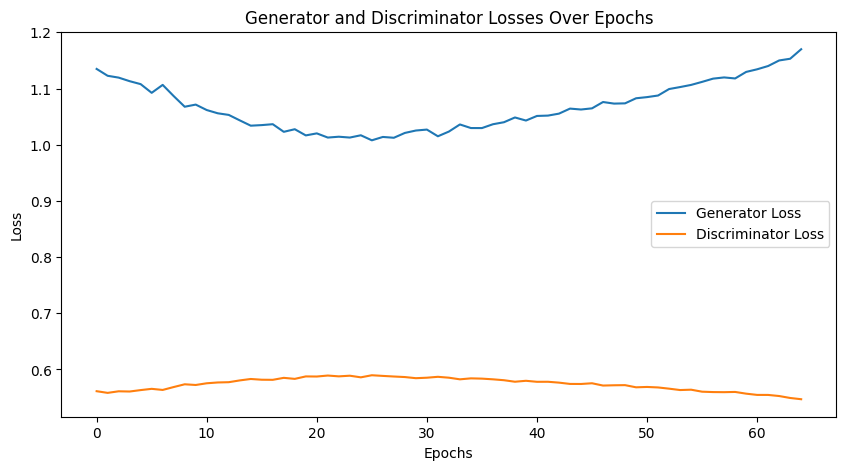

In [ ]:
loss_graph(g_losses=g_losses_epoch, d_losses=d_losses_epoch)

In [ ]:
optim_G = torch.optim.Adam(gen.generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
gen.zero_grad()
z_noise = torch.randn(128, 100, device=device)
x_fake_labels = torch.randint(0, 10, (128,), device=device)
x_fake = gen(z_noise, x_fake_labels)
y_fake_gs = [model(x_fake.detach(), x_fake_labels) for model in models]
real_ident = torch.full((128, 1), 1., device=device)
y_fake_g_means = [torch.mean(y).item() for y in y_fake_gs]
Dmax = models[y_fake_g_means.index(max(y_fake_g_means))]
y_fake_g = Dmax(x_fake, x_fake_labels)
g_loss = gen.loss(y_fake_g, real_ident)
g_loss.backward()
optim_G.step()

In [ ]:
optim_G = torch.optim.Adam(gen.generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
gen.zero_grad()
z_noise = torch.randn(128, 100, device=device)
x_fake_labels = torch.randint(0, 10, (128,), device=device)
x_fake = gen(z_noise, x_fake_labels)
y_fake_gs = [model(x_fake, x_fake_labels) for model in models]
real_ident = torch.full((128, 1), 1., device=device)
y_fake_g_means = [torch.mean(y).item() for y in y_fake_gs]
max_idx = y_fake_g_means.index(max(y_fake_g_means))
g_loss = gen.loss(y_fake_gs[max_idx], real_ident)
g_loss.backward()
optim_G.step()

In [ ]:
from flwr.server.client_proxy import ClientProxy
from flwr.common import FitRes, Status, Code, ndarrays_to_parameters, parameters_to_ndarrays

In [ ]:
params = [[val.cpu().numpy() for _, val in net.state_dict().items()] for net in models]

In [ ]:
params_converted = [ndarrays_to_parameters(param) for param in params]

In [ ]:
results = [(i, FitRes(status=Status(code=Code.OK, message="Success"), parameters=param, num_examples=len(train_partition), metrics={})) for i, param, train_partition in zip(range(num_partitions), params_converted, train_partitions)]

In [ ]:
from flwr.server.strategy.aggregate import aggregate_inplace

In [ ]:
aggregated_ndarrays = aggregate_inplace(results)

In [ ]:
parameters_aggregated_gen = ndarrays_to_parameters(aggregated_ndarrays)

In [ ]:
# Cria uma instância do modelo
model = CGAN()

In [ ]:
from collections import OrderedDict

In [ ]:
device = next(model.parameters()).device
params_dict = zip(model.state_dict().keys(), aggregated_ndarrays)
state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
model.load_state_dict(state_dict, strict=True)

<All keys matched successfully>

In [ ]:
def train_G(net: CGAN, device: str, lr: float, epochs: int, batch_size: int, latent_dim: int):
    net.to(device)  # move model to GPU if available
    optim_G = torch.optim.Adam(net.generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        # Train G
        net.zero_grad()
        z_noise = torch.randn(batch_size, latent_dim, device=device)
        x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)
        x_fake = net(z_noise, x_fake_labels)
        y_fake_g = net(x_fake, x_fake_labels)
        real_ident = torch.full((batch_size, 1), 1., device=device)
        g_loss = net.loss(y_fake_g, real_ident)
        g_loss.backward()
        optim_G.step()

In [ ]:
train_G(net=model,
        device=device,
        lr=0.0001,
        epochs=2,
        batch_size=128,
        latent_dim=100)

In [ ]:
type(parameters_aggregated_gen)

flwr.common.typing.Parameters

In [ ]:
params = [val.cpu().numpy() for _, val in model.state_dict().items()]

In [ ]:
param = ndarrays_to_parameters(params)

In [ ]:
type(param)

flwr.common.typing.Parameters